# Dataset Preparation

# Imports

In [1]:
# Import libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.transforms import Resize, InterpolationMode
import torchaudio
from torchaudio.transforms import MelSpectrogram, FrequencyMasking
import librosa
import cv2
from pathlib import Path
from os import listdir, scandir

# Helper functions

In [2]:
def plot_spectogram(specgram, title=None, ylabel='freq_bin'):
    _, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin='lower', aspect='auto')

# Start preparing dataset

In [3]:
workdir_path = Path('../data')
sample_rate = 48000

data = []
with scandir(workdir_path) as entries:
    for entry in entries:
        if entry.is_dir():
            path_to_dir = workdir_path / entry.name

            for filename in listdir(path_to_dir):
                path_to_audio = path_to_dir / filename

                data.append((path_to_audio, int(filename[0])))

audio_df = pd.DataFrame(data, columns=['path_to_audio', 'class'])

audio_df

,path_to_audio,class
0,../data/59/7_59_29.wav,7
1,../data/59/7_59_15.wav,7
2,../data/59/2_59_1.wav,2
3,../data/59/3_59_1.wav,3
4,../data/59/9_59_22.wav,9
...,...,...
29995,../data/25/5_25_27.wav,5
29996,../data/25/5_25_33.wav,5
29997,../data/25/7_25_2.wav,7
29998,../data/25/6_25_2.wav,6


In [4]:
n_classes = audio_df['class'].max() + 1
print(f'There are {n_classes} classes in the dataset')

There are 10 classes in the dataset


# Create dataset

In [5]:
n_channels = 1
n_mels = 24
time = 48

transform = torch.nn.Sequential(
    MelSpectrogram(sample_rate, n_fft=1024, n_mels=n_mels),
    Resize(size=(n_mels, time), interpolation=InterpolationMode.NEAREST)
)

../data/59/7_59_29.wav
sample_bilateral.shape: torch.Size([1, 24, 48]), sample_bilateral.class: 7


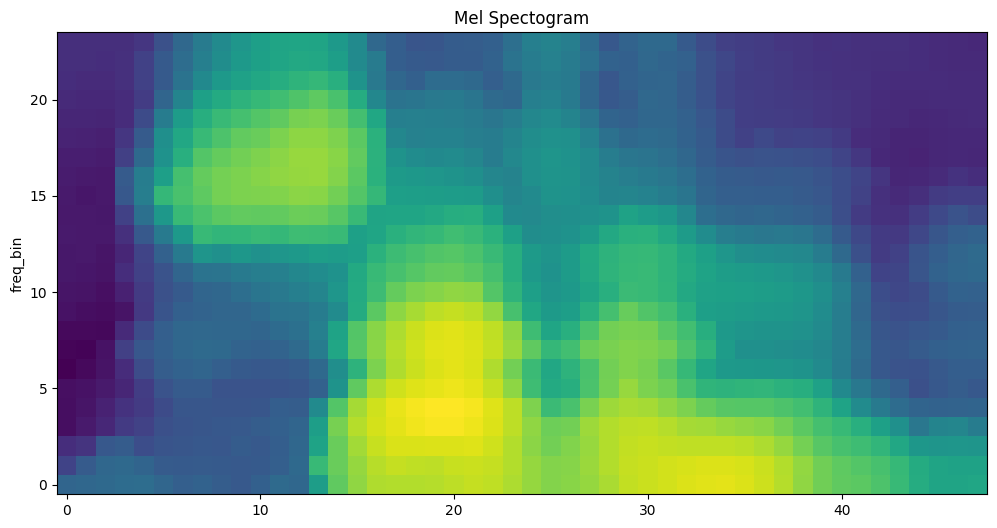

In [6]:
class BilateralAudioDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform
        self.d = 5
        self.sigmaColor = 10
        self.sigmaSpace = 10

    def __getitem__(self, i):
        path_to_audio, class_label = self.df.iloc[i]
        print(path_to_audio)
        waveform, _ = torchaudio.load(path_to_audio, normalize=True)

        specgram = self.transform(waveform)

        specgram = self.apply_filter(specgram)

        return specgram, class_label

    def __len__(self):
        return self.df.shape[0]

    def apply_filter(self, specgram):
        filtered_channels = []
        for channel in range(specgram.shape[0]):
            specgram_channel_np = specgram[channel].numpy()
            filtered_channel_np = cv2.bilateralFilter(
                specgram_channel_np.astype(np.float32),
                self.d,
                self.sigmaColor,
                self.sigmaSpace,
            )
            filtered_channels.append(torch.from_numpy(filtered_channel_np))
            filtered_specgram = torch.stack(filtered_channels)
            
        return filtered_specgram

ds = BilateralAudioDataset(audio_df, transform)
sample_bilateral = ds[0]
plot_spectogram(sample_bilateral[0][0], 'Mel Spectogram')
print(f'sample_bilateral.shape: {sample_bilateral[0].shape}, sample_bilateral.class: {sample_bilateral[1]}')
plt.savefig('sample_bilateral.png')
